SRILM and Wikitext-103 Exploration
===

SRILM is a languauge modeling toolkit that can be downloaded by researchers here: http://www.speech.sri.com/projects/srilm/download.html

Wikitext-103: https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/

In [4]:
from pathlib import Path

In [2]:
srilm = "/home/levon003/bin/srilm/bin/i686-m64/ngram-count"

In [7]:
wikitext_dir = Path("/home/levon003/data/wikitext-103/")
train = wikitext_dir / "wiki.train.tokens"
valid = wikitext_dir / "wiki.valid.tokens"
test = wikitext_dir / "wiki.test.tokens"
assert train.exists() and valid.exists() and test.exists()

In [211]:
# Each wikitext-103 file contains contents that are 
!head -n 10 {train}

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

In [15]:
!{srilm} -text {train} -write train.n1.count -sort -order 1

In [18]:
!awk '{print $NF" " $0 }' train.n1.count | sort -nr -k1 > train.n1.count.sorted

In [19]:
!head -n 20 train.n1.count.sorted

5584823 the	5584823
4971506 ,	4971506
3624899 .	3624899
2737620 of	2737620
2499539 and	2499539
1979164 to	1979164
1894558 in	1894558
1677048 a	1677048
1466599 =	1466599
1338685 "	1338685
1165029 <s>	1165029
1165029 </s>	1165029
1075325 was	1075325
881576 @-@	881576
853819 The	853819
728291 's	728291
688528 on	688528
679711 that	679711
675287 for	675287
675032 as	675032


In [21]:
# number of words in the vocab!
!wc -l train.n1.count.sorted

267736 train.n1.count.sorted


In [177]:
with open("train.n1.count.sorted") as infile:
    lines = [(int(line.split()[0]), line.split()[1]) for line in infile.readlines()]
    trimmed_lines = [(count, word) for count, word in lines if word.isalpha()]
    counts, words = zip(*trimmed_lines)
assert len(counts) == len(words)
counts[:10]

(5584823,
 2737620,
 2499539,
 1979164,
 1894558,
 1677048,
 1075325,
 853819,
 688528,
 679711)

In [184]:
print(f"{len(counts)} tokens with exclusively alpha characters.")
print("Top 20 tokens and their counts:")
print("(Total percentage of words using only this token)")
print("="*27)
total_count = np.sum(counts)
for i in range(20):
    cumulative_percentage_of_counts = np.sum(counts[:i+1]) / total_count * 100
    print(f"{words[i]:6} {counts[i]:>10}  ({cumulative_percentage_of_counts:5.2f}%)")

255356 tokens with exclusively alpha characters.
Top 20 tokens and their counts:
(Total percentage of words using only this token)
the       5584823  ( 6.83%)
of        2737620  (10.18%)
and       2499539  (13.23%)
to        1979164  (15.66%)
in        1894558  (17.97%)
a         1677048  (20.02%)
was       1075325  (21.34%)
The        853819  (22.38%)
on         688528  (23.22%)
that       679711  (24.06%)
for        675287  (24.88%)
as         675032  (25.71%)
with       632025  (26.48%)
by         600898  (27.21%)
is         512782  (27.84%)
his        436363  (28.38%)
from       431900  (28.90%)
at         417082  (29.41%)
were       354550  (29.85%)
it         326416  (30.25%)


In [187]:
# by the way, speaking of "his"...
his_count = np.sum(counts[words.index("his")])
her_count = np.sum(counts[words.index("her")]) + np.sum(counts[words.index("hers")])
his_pct = his_count / total_count * 100
her_pct = her_count / total_count * 100
print(f"'his' ({his_pct:.2f}%, {his_count}) is {his_pct / her_pct:.1f}x times more common than 'her'/'hers' ({her_pct:.2f}%, {her_count}). 🤔")

'his' (0.53%, 436363) is 2.5x times more common than 'her'/'hers' (0.22%, 177068). 🤔


In [202]:
%matplotlib inline

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_width = 12
plot_height = 8

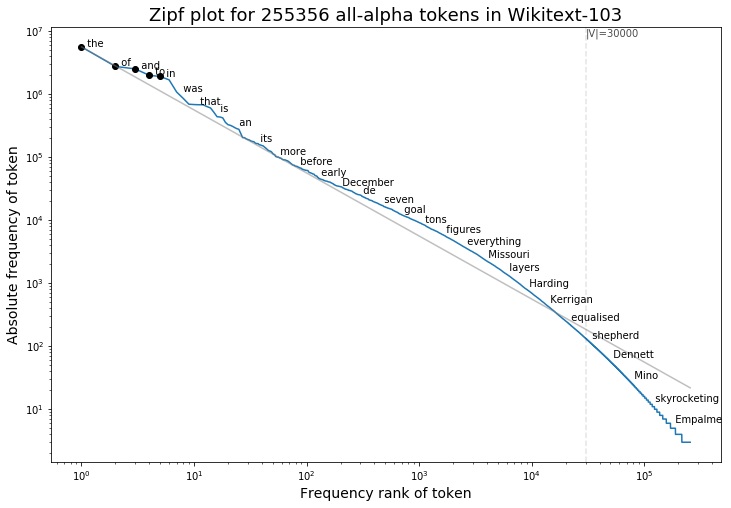

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(plot_width,plot_height))

# plot word rank vs word count
ax.loglog(range(1, len(counts)+1), counts)

# plot the the top 5 words specifically
ax.plot(range(1,6), counts[:5], 'ko')
for i in range(0, 5):
    ax.text(i+1, counts[i], "  " + words[i])
    
# print evenly-spaced sample words from the distribution
for rank in np.geomspace(6, len(counts), endpoint=False, num=25):
    i = int(rank)
    ax.text(i+1, counts[i], "  " + words[i])

# compute and plot the counts if the true distribution was Zipfian
largest = counts[0]
true_zipf = [(1, largest)]
for i in np.geomspace(1, len(counts), endpoint=True, num=25):
    rank = int(i) + 1
    true_zipf.append((rank, largest * 1/rank))
xs, ys = zip(*true_zipf)
ax.plot(xs, ys, color='gray', linestyle='-', alpha=0.5)
    
# label axes and add 30000 line as sample vocab size
plt.axvline(30000, color='black', linestyle='--', alpha=0.1)
plt.text(30000, plt.ylim()[1] * 0.7, "|V|=30000", alpha=0.7)
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.title(f"Zipf plot for {len(words)} all-alpha tokens in Wikitext-103")
plt.show()

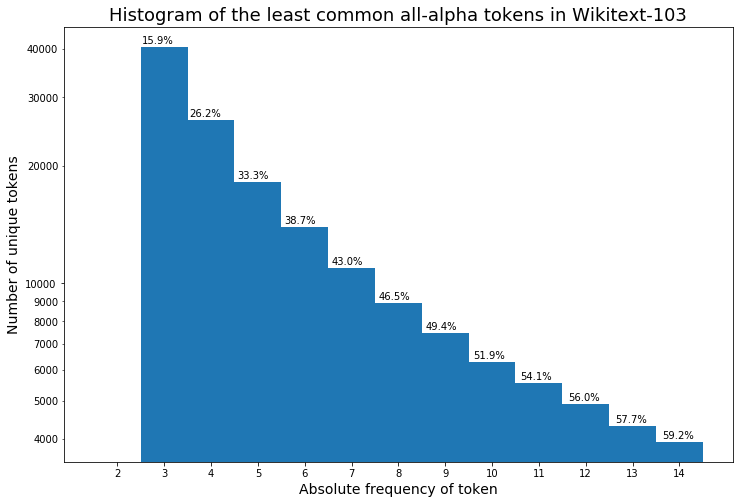

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(plot_width,plot_height))
least_common_words = [count for count in counts if count < 15]
bin_counts, _, _ = ax.hist(least_common_words, log=True, bins=range(2, 16), align='left')

# plot the cumulative percentage of unique words with at least this number of occurrences
cumulative_total = 0
for i, bin_count in enumerate(bin_counts[1:]):
    cumulative_total += bin_count
    pct = cumulative_total / len(words)
    ax.text((i + 3) * 1.01 - 0.5, bin_count * 1.02, f"{pct*100:.1f}%")

from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
plt.xticks(range(2,15))
plt.xlabel("Absolute frequency of token")
plt.ylabel("Number of unique tokens")
plt.title(f"Histogram of the least common all-alpha tokens in Wikitext-103")
plt.show()

In [213]:
# compute wikitext counts for bigrams and trigrams
!{srilm} -text {train} -write train.n2.count -sort -order 2
!awk '{print $NF" " $0 }' train.n2.count | sort -nr -k1 > train.n2.count.sorted
!{srilm} -text {train} -write train.n3.count -sort -order 3
!awk '{print $NF" " $0 }' train.n3.count | sort -nr -k1 > train.n3.count.sorted

In [216]:
!wc -l *.count.sorted | sort -nr

  74862573 total
  51977781 train.n3.count.sorted
  11308528 train.n2.count.sorted
  11308528 train.count.sorted
    267736 train.n1.count.sorted


In [215]:
with open("train.n2.count.sorted") as infile:
    lines = [(int(line.split()[0]), line.split()[1:-1]) for line in infile.readlines()]
    bigram_counts, bigram_words = zip(*lines)
assert len(bigram_counts) == len(bigram_words)

TypeError: slice indices must be integers or None or have an __index__ method